In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
46689,NaN,NaN,International,2020-09-26,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46690,NaN,NaN,International,2020-09-27,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46691,NaN,NaN,International,2020-09-28,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


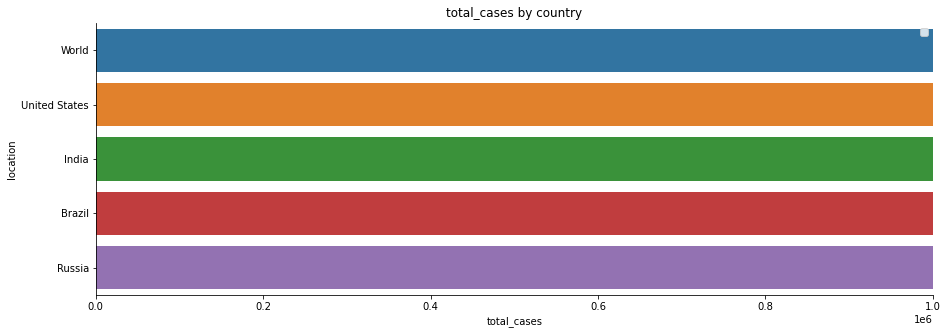

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


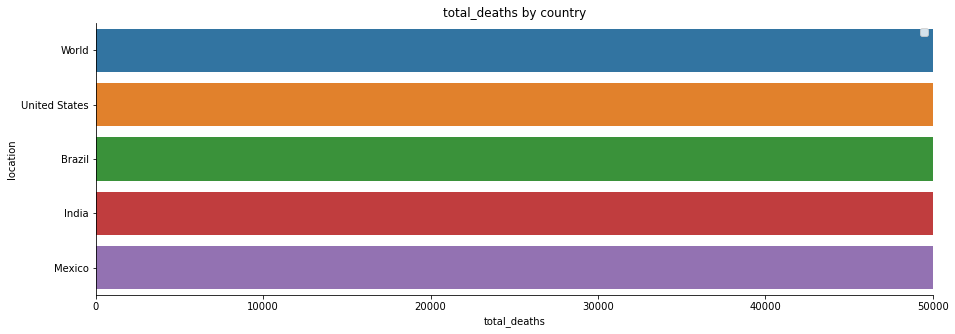

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


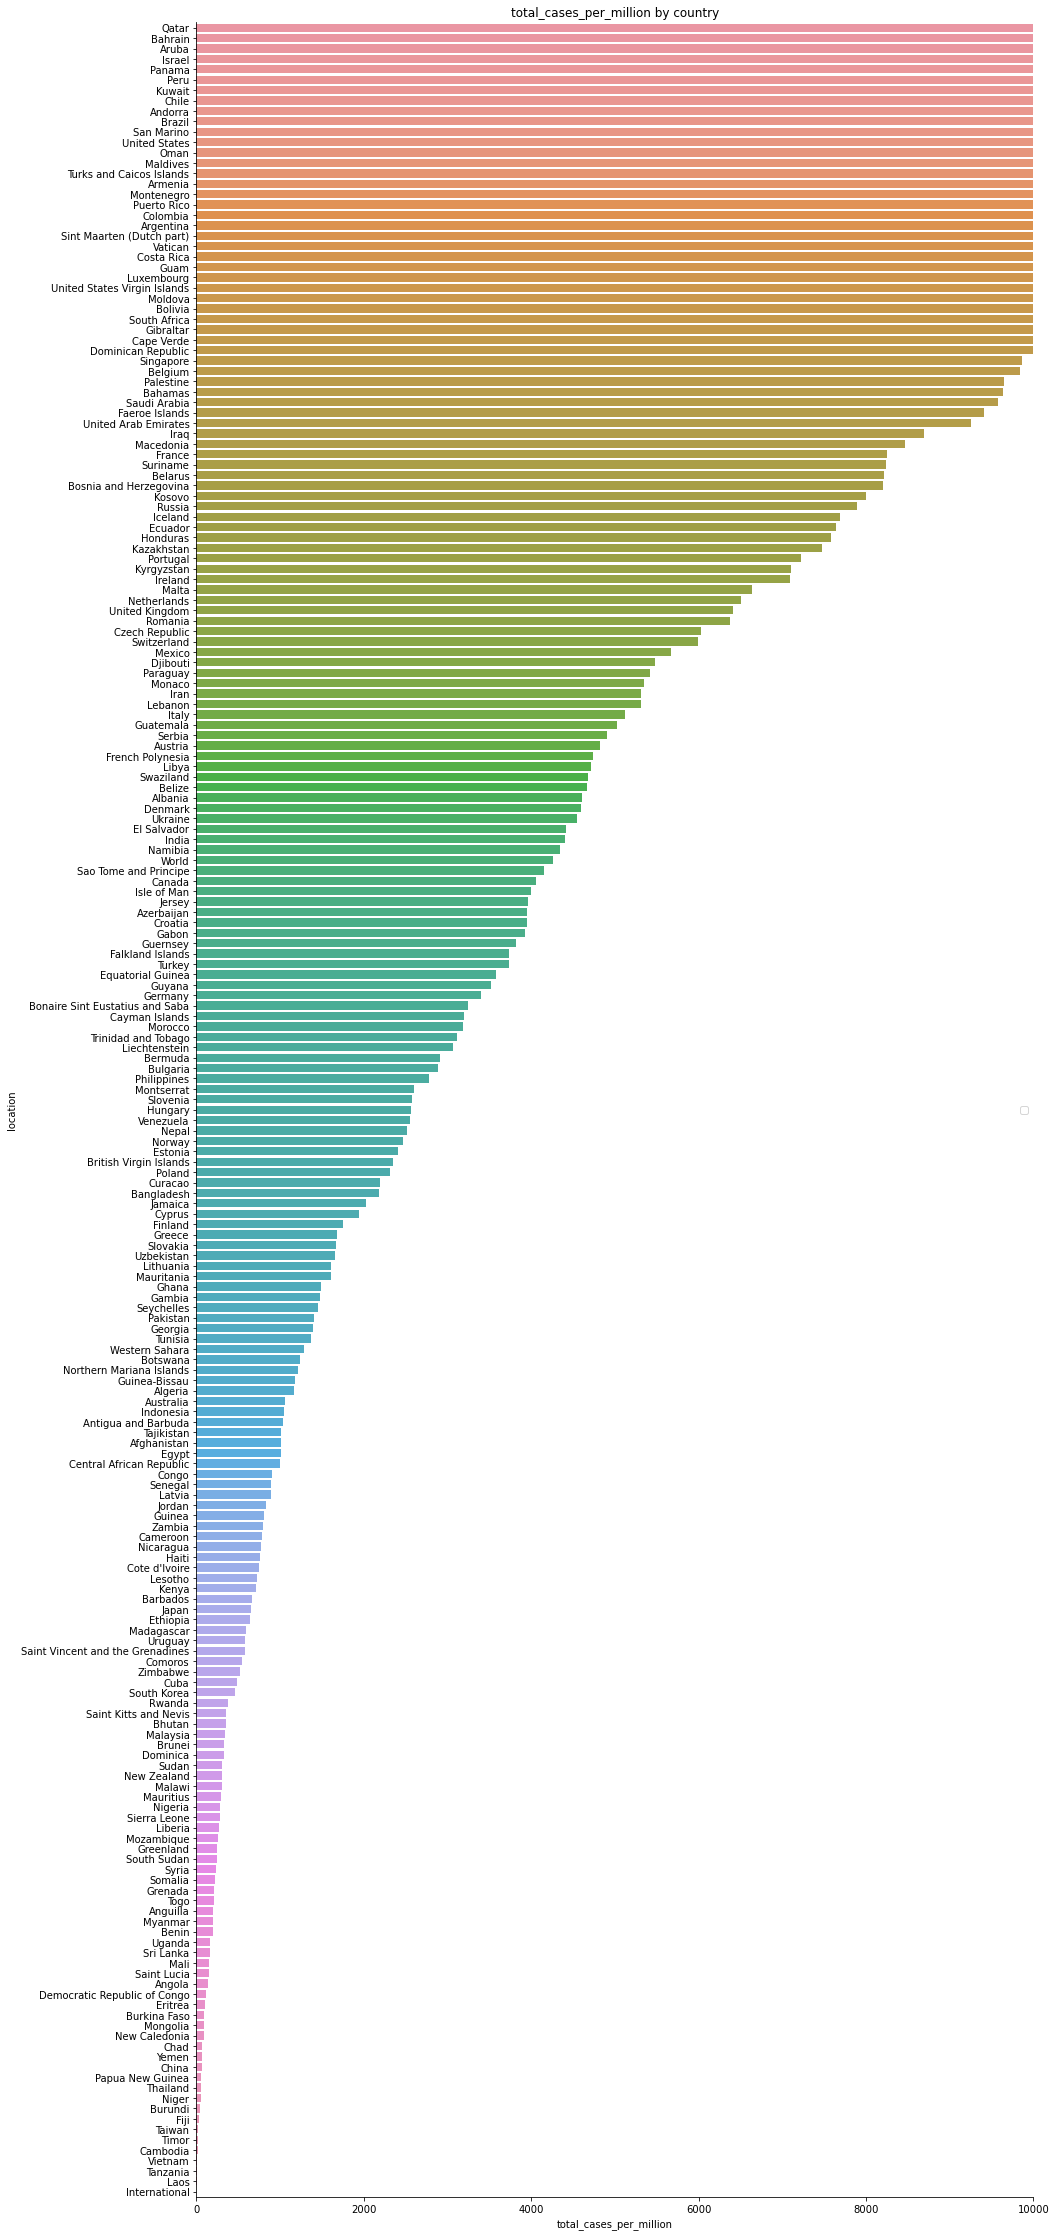

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


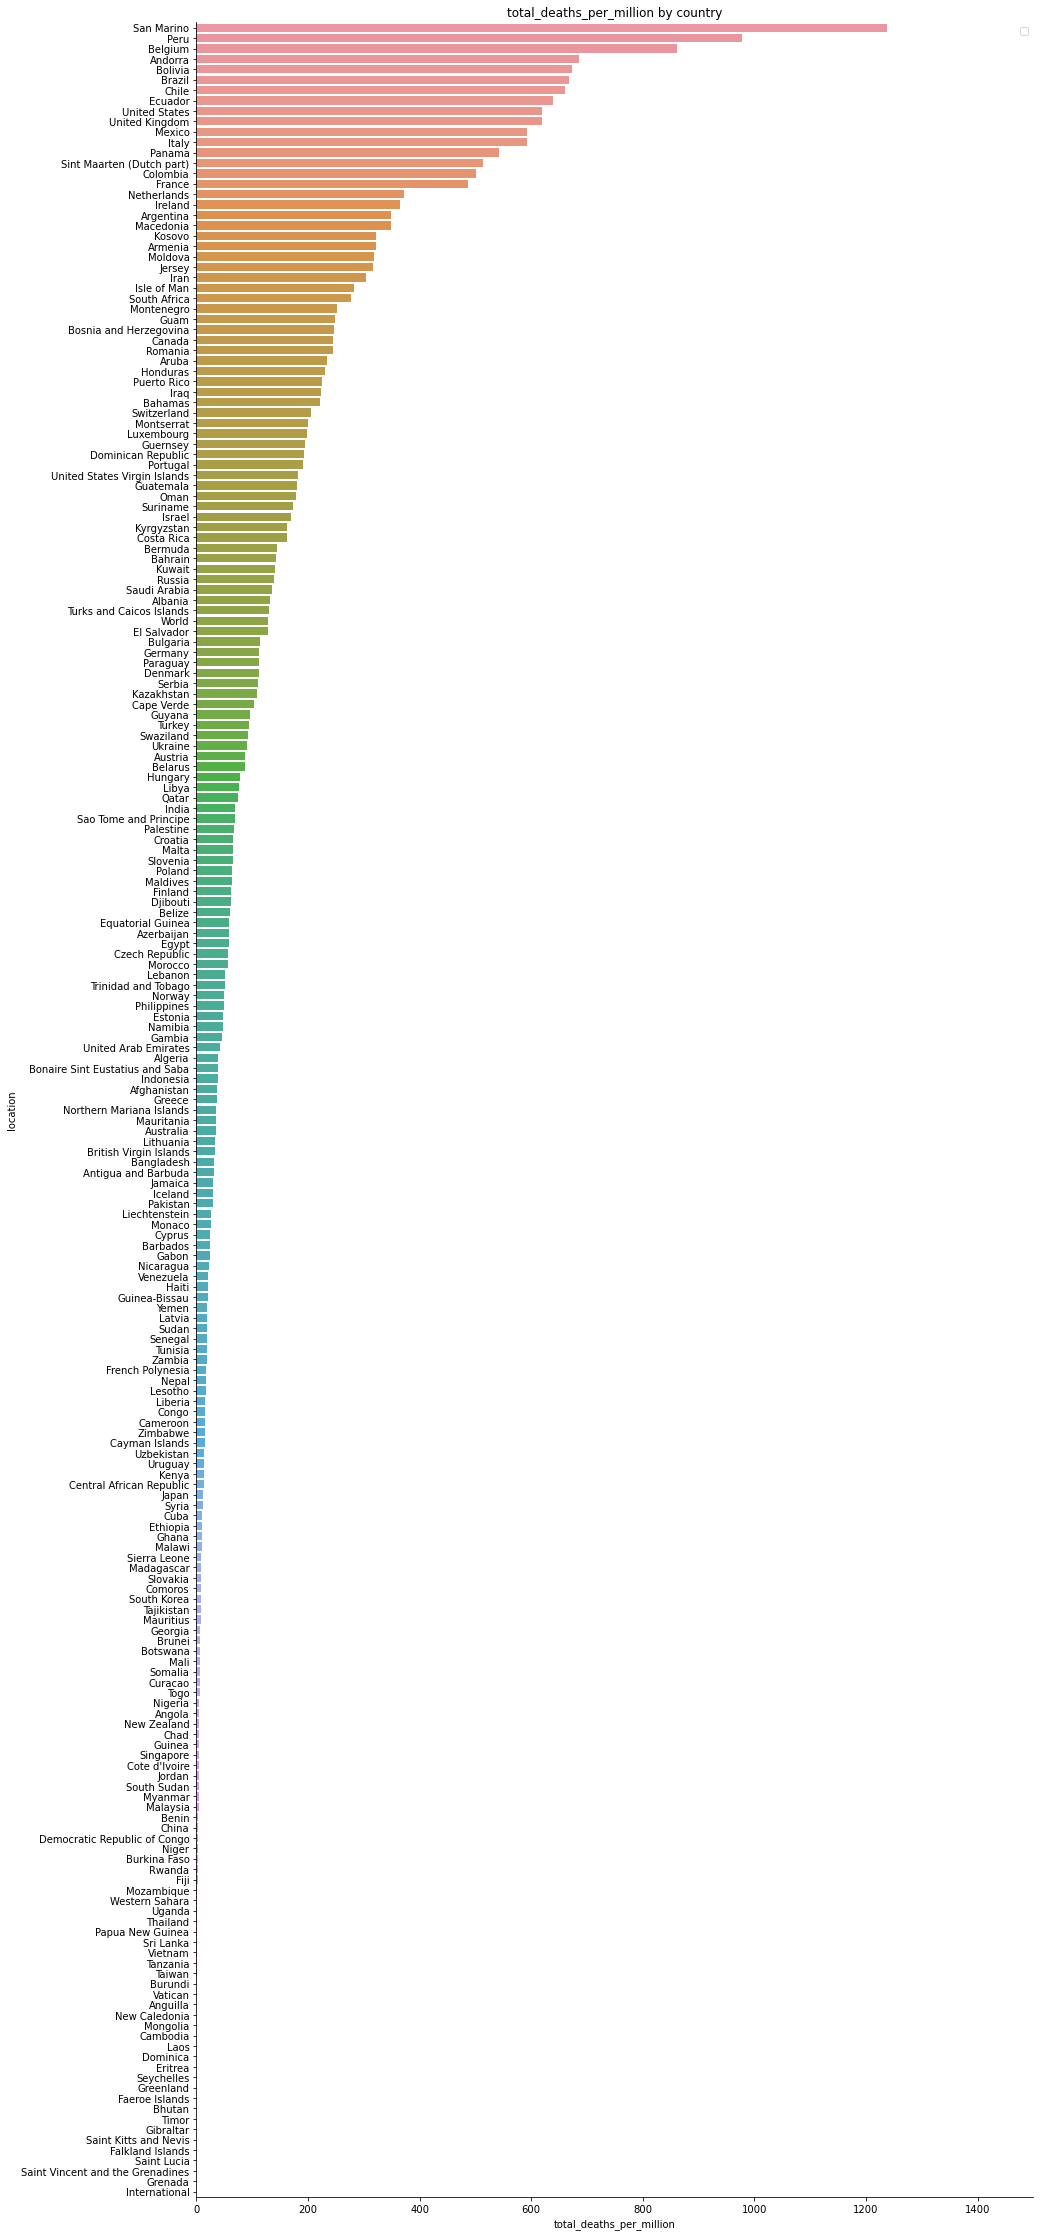

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

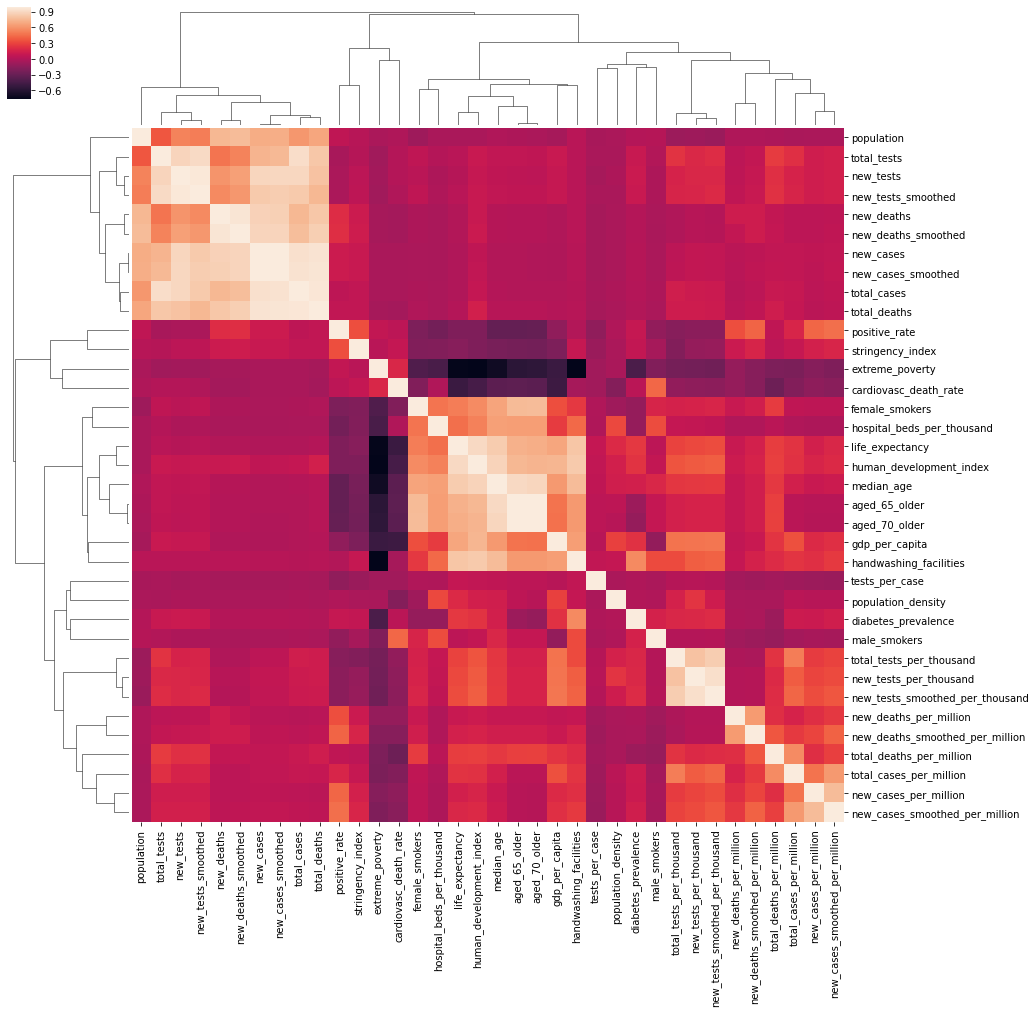

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.99841362558262 (+/- 0.002096237901969239)
Coef :  [1.03053098e+00 7.74649211e-05 7.95971418e-05]
3 Last_days :  [[32616929 32918083 33178019]]
Today :  33178019
Prediction + :  548625
Tomorow :  33726644
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996048521163682 (+/- 0.00018307294396297468)
Coef :  [0.25763503 0.36589977 0.38638693]
3 Last_days :  [[989733 995151 998784]]
Today :  998784
Prediction + :  9749
Tomorow :  1008533
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.6568102573152652 (+/- 2.3390753487148683)
Coef :  [-0.73002685  0.77068716  0.96600542]
3 Last_days :  [[513034 527446 538569]]
Today :  538569
Prediction + :  13479
Tomorow :  552048
                                     
--------- Total Death -----------------
                                     
R^2: 0.7610666076571363 (+/- 0.3304121839223233)
Coef :  [-0.74424979  0.78708262  0.95611889]
3 Last_days :  [[31661 31700 31727]]
Today :  31727
Prediction + :  48
Tomorow :  31775
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9703344166883721 (+/- 0.03143804781902084)
Coef :  [-0.33118005 -0.00811403  1.33355924]
3 Last_days :  [[90441 90456 90483]]
Today :  90483
Prediction + :  22
Tomorow :  90505
                                     
--------- Total Death -----------------
                                     
R^2: -19.16026131616705 (+/- 28.409940579379164)
Coef :  [-0.07777414  0.01249371  1.05694258]
3 Last_days :  [[4739 4739 4739]]
Today :  4739
Prediction + :  5
Tomorow :  4744
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9607479470529565 (+/- 0.05430950245912353)
Coef :  [-0.80654567  0.88999217  0.91607263]
3 Last_days :  [[306235 308104 309870]]
Today :  309870
Prediction + :  1616
Tomorow :  311486
                                     
--------- Total Death -----------------
                                     
R^2: -0.1506246434913179 (+/- 1.60857719753423)
Coef :  [-0.81757684  0.89424787  0.92230445]
3 Last_days :  [[35801 35818 35835]]
Today :  35835
Prediction + :  32
Tomorow :  35867
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.3841883150462702 (+/- 1.94688960848433)
Coef :  [-0.26145241  0.15976921  1.10911309]
3 Last_days :  [[716481 716481 716481]]
Today :  716481
Prediction + :  5493
Tomorow :  721974
                                     
--------- Total Death -----------------
                                     
R^2: -0.6826687118053848 (+/- 2.0889477513934405)
Coef :  [-0.73105604  0.64627806  1.08378234]
3 Last_days :  [[31232 31232 31232]]
Today :  31232
Prediction + :  8
Tomorow :  31240
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.919350356963634 (+/- 0.1109229197805079)
Coef :  [0.17408021 0.41649077 0.42190351]
3 Last_days :  [[7033430 7078798 7115046]]
Today :  7115046
Prediction + :  79081
Tomorow :  7194127
                                     
--------- Total Death -----------------
                                     
R^2: 0.985851919660122 (+/- 0.018705983236282964)
Coef :  [-0.36090918  0.6520314   0.71163798]
3 Last_days :  [[203774 204497 204756]]
Today :  204756
Prediction + :  1234
Tomorow :  205990
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.943793267939984 (+/- 0.07857318389052788)
Coef :  [-0.70929578  0.84014398  0.87056084]
3 Last_days :  [[423236 429277 434969]]
Today :  434969
Prediction + :  4613
Tomorow :  439582
                                     
--------- Total Death -----------------
                                     
R^2: 0.1921865601525069 (+/- 1.1124514099096199)
Coef :  [-0.76178965  0.82924772  0.9317603 ]
3 Last_days :  [[41936 41971 41988]]
Today :  41988
Prediction + :  58
Tomorow :  42046
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.966457368133124 (+/- 0.04658716445408756)
Coef :  [-0.76817361  0.84463504  0.92354896]
3 Last_days :  [[282730 284140 285332]]
Today :  285332
Prediction + :  1326
Tomorow :  286658
                                     
--------- Total Death -----------------
                                     
R^2: 0.19311183093405906 (+/- 1.1328647229121913)
Coef :  [-0.78129528  0.83804181  0.94242968]
3 Last_days :  [[9452 9457 9460]]
Today :  9460
Prediction + :  9
Tomorow :  9469
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9946217281773371 (+/- 0.005977326949559875)
Coef :  [0.39208112 0.31177807 0.30767971]
3 Last_days :  [[439882 443086 446448]]
Today :  446448
Prediction + :  3193
Tomorow :  449641
                                     
--------- Total Death -----------------
                                     
R^2: 0.9156092817431823 (+/- 0.11847650422811577)
Coef :  [0.21012666 0.40694033 0.39440498]
3 Last_days :  [[25222 25394 25589]]
Today :  25589
Prediction + :  211
Tomorow :  25800
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995540047869009 (+/- 0.0003689352926926473)
Coef :  [-0.59333619  0.78293945  0.80779933]
3 Last_days :  [[311455 312966 314433]]
Today :  314433
Prediction + :  1218
Tomorow :  315651
                                     
--------- Total Death -----------------
                                     
R^2: 0.9991108439642685 (+/- 0.0008645216901587987)
Coef :  [-0.81770744  0.89722561  0.91905221]
3 Last_days :  [[7858 7929 7997]]
Today :  7997
Prediction + :  58
Tomorow :  8055
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9590851077664819 (+/- 0.053363973819417355)
Coef :  [-0.10617614  0.50809997  0.60958019]
3 Last_days :  [[4689613 4717991 4732309]]
Today :  4732309
Prediction + :  60952
Tomorow :  4793261
                                     
--------- Total Death -----------------
                                     
R^2: 0.451117497607838 (+/- 0.7689093127820321)
Coef :  [-0.00628896  0.47761913  0.53856565]
3 Last_days :  [[140537 141406 141741]]
Today :  141741
Prediction + :  1612
Tomorow :  143353
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(33178019, 998784, 33726644, 1008533),
 (538569, 31727, 552048, 31775),
 (309870, 35835, 311486, 35867),
 (716481, 31232, 721974, 31240),
 (7115046, 204756, 7194127, 205990),
 (90483, 4739, 90505, 4744),
 (434969, 41988, 439582, 42046),
 (285332, 9460, 286658, 9469),
 (446448, 25589, 449641, 25800),
 (314433, 7997, 315651, 8055),
 (4732309, 141741, 4793261, 143353)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-28,France,552048.0,0.0,31775.0,0.0,0.0,0.0
0,2020-09-28,China,90505.0,0.0,4744.0,0.0,0.0,0.0
0,2020-09-28,Italy,311486.0,0.0,35867.0,0.0,0.0,0.0
0,2020-09-28,Spain,721974.0,0.0,31240.0,0.0,0.0,0.0
0,2020-09-28,United States,7194127.0,0.0,205990.0,0.0,0.0,0.0
0,2020-09-28,World,33726644.0,0.0,1008533.0,0.0,0.0,0.0
0,2020-09-28,United Kingdom,439582.0,0.0,42046.0,0.0,0.0,0.0
0,2020-09-28,Germany,286658.0,0.0,9469.0,0.0,0.0,0.0
0,2020-09-28,Iran,449641.0,0.0,25800.0,0.0,0.0,0.0
0,2020-09-28,Turkey,315651.0,0.0,8055.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")